In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import progressbar

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        
#                         for i in range(len(label)):
#                             if label[i] == 'NA':
#                                 label[i] = 'O'
                        n_labels = set(label)
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence.append(('.', 'O'))
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [4]:
data_list = read_data('../data/input/GO/merged/')

print data_list[0]

# data_list = data_list[:3000]

# words = list(chain.from_iterable(data_list))
# print words

print len(data_list)

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words)
print n_words

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print n_tags

[('A', 'O'), ('Hybrid', 'O'), ('Photoreceptor', 'O'), ('Expressing', 'GO:0010467'), ('Both', 'O'), ('Rod', 'O'), ('and', 'O'), ('Cone', 'O'), ('Genes', 'O'), ('in', 'O'), ('a', 'O'), ('Mouse', 'O'), ('Model', 'O'), ('of', 'O'), ('Enhanced', 'O'), ('SCone', 'O'), ('Syndrome', 'O'), ('.', 'O')]
9571
17921
359


In [5]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list(y[1] for x in data_list for y in x))

# labels2idx = dict(zip(le.classes_, le.transform(le.classes_)))

# idx2la = {labels2idx[k]:k for k in labels2idx}

In [6]:
max_len = 75
max_len_char = 10

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

print word2idx['Hybrid']
print tag2idx["O"]

964
0


In [7]:
print tag2idx

{'GO:0007599': 1, 'GO:0007596': 2, 'GO:0006900': 3, 'GO:0001501': 4, 'GO:0001503': 5, 'GO:0006909': 6, 'GO:0001966': 296, 'GO:0000003': 8, 'GO:0043209': 9, 'GO:0005835': 10, 'GO:0005833': 11, 'GO:0016458': 12, 'GO:0016459': 13, 'GO:0018032': 14, 'GO:0006281': 15, 'GO:0006289': 16, 'GO:0007283': 17, 'GO:0007286': 18, 'GO:0001756': 19, 'GO:0001750': 20, 'GO:0000718': 21, 'GO:0045251': 22, 'GO:0006271': 23, 'GO:0009566': 24, 'GO:0020021': 25, 'GO:0006457': 26, 'GO:0000811': 27, 'GO:0005488': 28, 'GO:0050789': 29, 'GO:0042555': 30, 'GO:0042552': 31, 'GO:0043679': 32, 'GO:0006887': 33, 'GO:0005712': 34, 'GO:0005654': 35, 'GO:0005656': 36, 'GO:0005657': 37, 'GO:0032259': 38, 'GO:0043025': 39, 'GO:0019882': 40, 'GO:0007620': 41, 'GO:0009305': 42, 'GO:0007050': 43, 'GO:0043412': 44, 'GO:0043413': 45, 'GO:0000237': 46, 'GO:0000239': 47, 'GO:0000238': 48, 'GO:0043204': 49, 'GO:0030674': 50, 'GO:0005776': 186, 'GO:0005871': 52, 'GO:0019814': 53, 'GO:0005874': 54, 'GO:0045177': 306, 'GO:0043489': 

In [8]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data_list]

In [9]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["O"], padding='post', truncating='post')

In [10]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

104


In [11]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [12]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [13]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]

In [14]:
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [15]:
from keras.utils import to_categorical

y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [16]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [17]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras_contrib.layers import CRF

# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=len(tag2idx),
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(GRU(units=150, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(GRU(units=100, return_sequences=True,
                               recurrent_dropout=0.6))(x)
model = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

crf = CRF(n_tags+1)  # CRF layer
out = crf(model)  # output

model = Model([word_in, char_in], out)

In [18]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

In [19]:
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 100)  10600       input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 359)      6434357     input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [20]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr),
                    batch_size=32, epochs=15, validation_data=([X_word_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
                    np.array(y_te)),
                    verbose=1)

Train on 6699 samples, validate on 2872 samples
Epoch 1/15
6699/6699 [==============================] - 95s 14ms/step - loss: 16.7115 - viterbi_acc: 0.9265 - val_loss: 16.8921 - val_viterbi_acc: 0.9465
Epoch 2/15
6699/6699 [==============================] - 95s 14ms/step - loss: 16.4664 - viterbi_acc: 0.9547 - val_loss: 16.8141 - val_viterbi_acc: 0.9582
Epoch 3/15
6699/6699 [==============================] - 94s 14ms/step - loss: 16.3914 - viterbi_acc: 0.9649 - val_loss: 16.7675 - val_viterbi_acc: 0.9691
Epoch 4/15
6699/6699 [==============================] - 94s 14ms/step - loss: 16.3468 - viterbi_acc: 0.9724 - val_loss: 16.7297 - val_viterbi_acc: 0.9754
Epoch 5/15
6699/6699 [==============================] - 94s 14ms/step - loss: 16.3195 - viterbi_acc: 0.9770 - val_loss: 16.7193 - val_viterbi_acc: 0.9777
Epoch 6/15
6699/6699 [==============================] - 94s 14ms/step - loss: 16.3013 - viterbi_acc: 0.9797 - val_loss: 16.7209 - val_viterbi_acc: 0.9802
Epoch 7/15
6699/6699 [======

In [21]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_merged_CHAR_GRU_Based_test.tsv', sep='\t')

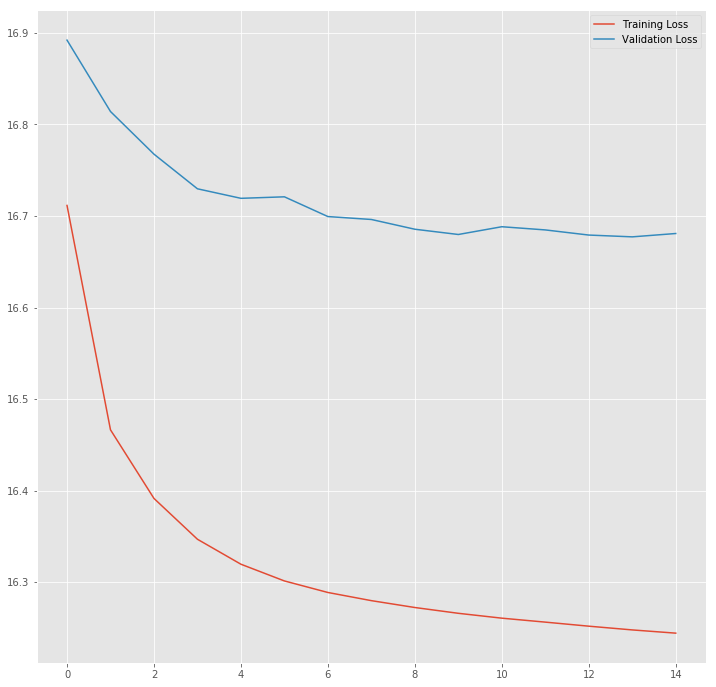

In [22]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

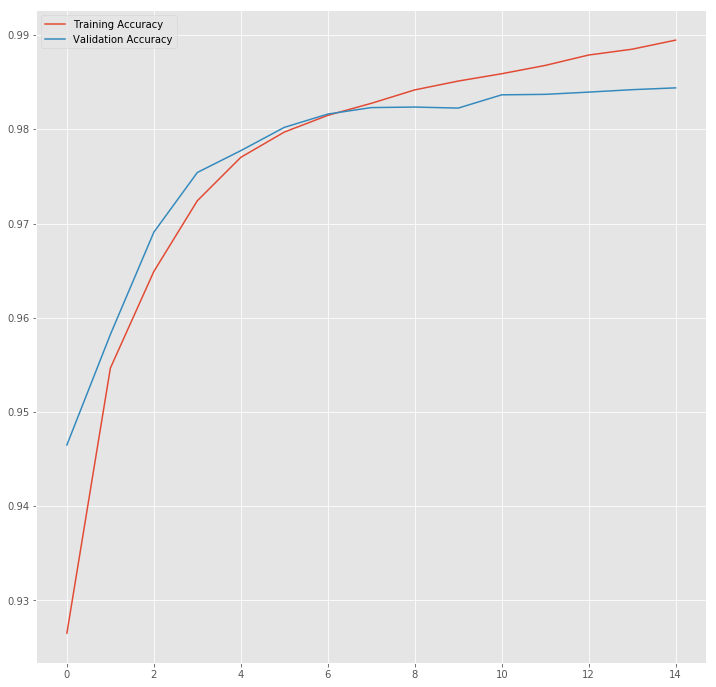

In [23]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["viterbi_acc"], label='Training Accuracy')
plt.plot(hist["val_viterbi_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

print word[2]
print predicted_val[2]
print true[2]

wd = [list(map(lambda x: idx2word[x], y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]


print wd[2]
print p[2]
print t[2]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
print "\n"
print report

[10312 13941 15001 15504  2040   703     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[  0   0   0   0 221   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[  0   0   0   0 221   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0 

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [25]:
i = 300
pred = np.argmax(predicted[i], axis=-1)
print pred
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], np.argmax(y_te[i], -1), pred):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w], idx2tag[tr], idx2tag[pred]))
        
# pd = model.predict(np.array([X_te[i]]))
# pd = np.argmax(pd, axis=-1)
# true = np.argmax(y_te[i], -1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")

# for w, t1, pred in zip(X_te[i], true, pd[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

[  0   0   0   0   0   0   0   0 288   0   0   0   0   0 261   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
Word           ||True ||Pred
anesthetic     : O     O
Abcam          : O     O
“naïve”   : O     O
brains         : O     O
AtrxΔ18Δneo  : O     O
demonstrates   : O     O
Boundary       : O     O
trypsinlike    : O     O
Function       : GO:0005694 GO:0005694
antiPcad       : O     O
follicle       : O     O
methylglyoxal  : O     O
spread         : O     O
neither        : O     O
poorly         : O     GO:0009058
Occurrence     : O     O


In [26]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [27]:
df = df[df['Word'] != 'O']

In [28]:
df.to_csv('../data/results/GO_merged_CHAR_GRU_Based_CRF.tsv', sep='\t')

In [29]:
%run ./accuracy/src/computeSim.py ../data/results/GO_merged_CHAR_GRU_Based_CRF.tsv ../data/validation_data/GO_AllSubsumers.tsv

Mean semantic similarity:  0.825
